In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


def preprocess(data):
    """
    数据预处理
    """
    #获取维度
    n, d = data.shape
    #分离X
    X = data[:, :-1]
    #添加偏置项1
    X = np.c_[np.ones(n), X]
    #分离y
    y = data[:, -1]
    
    return X, y

def PLA(X, y, eta=1, max_step=np.inf):
    """
    PLA算法，X，y为输入数据，eta为步长，默认为1，max_step为最多迭代次数，默认为无穷
    """
    #获取维度
    n, d = X.shape
    #初始化
    w = np.zeros(d)
    #记录迭代次数
    t = 0
    #记录元素的下标
    i = 0
    #记录最后一个错误的下标
    last = 0
    while not(Judge(X, y, w)) and t < max_step:
        if np.sign(X[i, :].dot(w) * y[i]) <= 0:
            #迭代次数增加
            t += 1
            w += eta * y[i] * X[i, :]
            #更新最后一个错误
            last = i
        
        #移动到下一个元素
        i += 1
        #如果达到n，则重置为0
        if i == n:
            i = 0
    
    return t, last, w

def Pocket_PLA(X, y, eta=1, max_step=np.inf):
    """
    Pocket_PLA算法，X，y为输入数据，eta为步长，默认为1，max_step为最多迭代次数，默认为无穷
    """
    #获得数据维度
    n, d = X.shape
    #初始化
    w = np.zeros(d)
    #记录最优向量
    w0 = np.zeros(d)
    #记录次数
    t = 0
    #记录最少错误数量
    error = count(X, y, w0)
    #记录元素的下标
    i = 0
    #记录每一步的w
    W = []
    #记录最优w
    W_hat = []
    while (error != 0 and t < max_step):
        if np.sign(X[i, :].dot(w) * y[i]) <= 0:
            w += eta * y[i] * X[i, :]
            #迭代次数增加
            t += 1
            #记录当前错误
            error_now = count(X, y, w)
            if error_now < error:
                error = error_now
                w0 = np.copy(w)

            #记录最优w
            W_hat.append(np.copy(w0))
            #记录w
            W.append(np.copy(w))
        #移动到下一个元素
        i += 1
        #如果达到n，则重置为0
        if i == n:
            i = 0
    return np.array(W), np.array(W_hat), w0, error


In [9]:
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

#Step1产生数据
def generatedata(n, flag=True):
    """
    产生n组数据，10%为噪声，这里直线选择为y=x，y>x则标签为1，否则为-1
    x, y的范围都介于(-2, 2)，flag用于判断是否产生噪声
    """
    #产生X
    X = np.random.uniform(-2, 2, (n, 2))
    #计算标签
    y = np.ones(n)
    y[X[:, 0] <= X[:, 1]] = -1
    if flag:
        #让前10%数据误分
        y[: n//10] *= -1
    #合并数据
    Data = np.c_[X, y]
    #打乱数据
    np.random.shuffle(Data)
    
    return Data

In [10]:
D_train = generatedata(100)
X_train = D_train[:, :-1]
y_train = D_train[:, -1]
#后面两步是为了作图
#标签为+1的点
train_px = X_train[y_train > 0][:, 0]
train_py = X_train[y_train > 0][:, 1]
#标签为-1的点
train_nx = X_train[y_train < 0][:, 0]
train_ny = X_train[y_train < 0][:, 1]

In [11]:
D_test = generatedata(1000)
X_test = D_test[:, :-1]
y_test = D_test[:, -1]
#标签为+1的点
test_px = X_test[y_test > 0][:, 0]
test_py = X_test[y_test > 0][:, 1]
#标签为-1的点
test_nx = X_test[y_test < 0][:, 0]
test_ny = X_test[y_test < 0][:, 1]

x = [-2, 2]
y = [-2, 2]

/srv/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


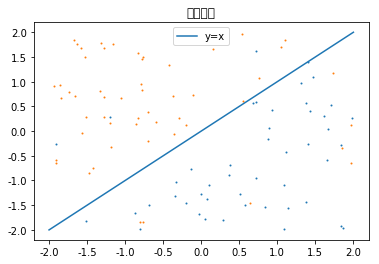

In [12]:
plt.scatter(train_px, train_py, s=1)
plt.scatter(train_nx, train_ny, s=1)
plt.title('训练数据')
plt.plot(x, y, label='y=x')
plt.legend()
plt.show()

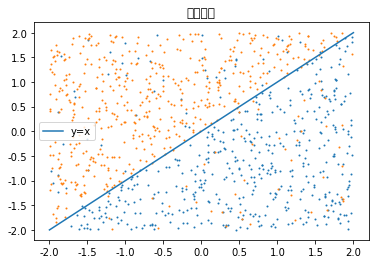

In [13]:
plt.scatter(test_px, test_py, s=1)
plt.scatter(test_nx, test_ny, s=1)
plt.title('测试数据')
plt.plot(x, y, label='y=x')
plt.legend()
plt.show()

In [14]:
n = 1000
k = 1
N = 20


In [15]:
def experiment(n, k):
    """
    模拟一次实验，n为迭代次数，k为步长
    """
    #训练数据
    D_train = generatedata(100)
    X_train, y_train = preprocess(D_train)
    
    #测试数据
    D_test = generatedata(1000)
    X_test, y_test = preprocess(D_test)
    
    #训练模型
    W, W_hat, w_hat, error = Pocket_PLA(X_train, y_train, k, n)
    
    #计算错误率
    ein = np.mean(np.sign(W.dot(X_train.T)) != y_train, axis=1)
    ein_hat = np.mean(np.sign(W_hat.dot(X_train.T)) != y_train, axis=1)
    eout = np.mean(np.sign(W.dot(X_test.T)) != y_test, axis=1)
    eout_hat = np.mean(np.sign(W_hat.dot(X_test.T)) != y_test, axis=1)
    return ein, ein_hat, eout, eout_hat


In [16]:
Ein = np.zeros(n)
Ein_hat = np.zeros(n)
Eout = np.zeros(n)
Eout_hat = np.zeros(n)

In [17]:
for i in range(N):
    ein, ein_hat, eout, eout_hat = experiment(n, k)
    Ein += ein
    Ein_hat += ein_hat
    Eout += eout
    Eout_hat += eout_hat

In [18]:
Ein /= N
Ein_hat /= N
Eout /= N
Eout_hat /= N

In [19]:
t = np.arange(1, n+1)

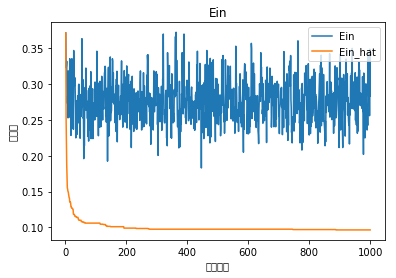

In [20]:
plt.plot(t, Ein, label='Ein')
plt.plot(t, Ein_hat, label='Ein_hat')
plt.title('Ein')
plt.xlabel('训练次数')
plt.ylabel('错误率')
plt.legend()
plt.show()

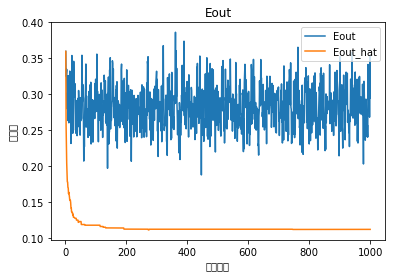

In [21]:
plt.plot(t, Eout, label='Eout')
plt.plot(t, Eout_hat, label='Eout_hat')
plt.title('Eout')
plt.xlabel('训练次数')
plt.ylabel('错误率')
plt.legend()
plt.show()